## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import cv2
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D, LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adagrad
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers, Model

from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications import MobileNetV3Small

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Large

import warnings
warnings.filterwarnings('ignore')

## Data Download

In [ ]:
! pip install --upgrade --force-reinstall --no-deps kaggle
import os
from google.colab import files

     |████████████████████████████████| 61kB 3.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=ce802414d5360d8c888a9321ff706963876fbe0c9a05740b34ce1c40daf1fbc3
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d prithwirajmitra/anpr-data
zip_obj = zipfile.ZipFile(r'/content/anpr-data.zip' , 'r')
zip_obj.extractall('Dataset')
os.remove(r"/content/anpr-data.zip")
os.remove(r"/content/kaggle.json")

## Data Preparation

In [ ]:
dataset_path = r"/content/Dataset/augmented images"

In [ ]:
data = pd.read_csv(r"/content/Dataset/AugmentData.csv")
print(data.shape)
data.head()

In [ ]:
fig = plt.figure(figsize=(22, 8))

rows = 2
columns = 4

for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)

    pos = np.random.randint(0, len(data) + 1)
    img = cv2.imread(os.path.join(dataset_path, data.loc[pos, "name"]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.rectangle(img, (data.loc[pos,"xmax"], data.loc[pos,"ymax"]), (data.loc[pos,"xmin"], data.loc[pos,"ymin"]), (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i}")

plt.show()

## Data changing for Model

In [ ]:
class data_split():
    def __init__(self, data):
        self.df = data
        self.train_img = []
        self.train_coors = []
        self.val_img = []
        self.val_coors = []
        self.test_img = []
        self.test_coors = []
    
    def split(self, train_percent=0.63, val_percent=0.80):
        self.df = self.df.sample(frac=1)
        self.df.reset_index(drop=True, inplace=True)

        train_data, val_data = train_test_split(self.df, train_size = train_percent, random_state = 42)
        val_data, test_data = train_test_split(val_data, train_size = val_percent, random_state = 42)
        train_data.reset_index(drop=True, inplace=True)
        val_data.reset_index(drop=True, inplace=True)
        test_data.reset_index(drop=True, inplace=True)

        for i in tqdm(range(len(train_data))):
            path = os.path.join(dataset_path, train_data.loc[i, "name"])
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.train_img.append(img)
            self.train_coors.append(train_data.iloc[i, 1:].values.tolist())
        
        for i in tqdm(range(len(val_data))):
            path = os.path.join(dataset_path, val_data.loc[i, "name"])
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.val_img.append(img)
            self.val_coors.append(val_data.iloc[i, 1:].values.tolist())
        
        for i in tqdm(range(len(test_data))):
            path = os.path.join(dataset_path, test_data.loc[i, "name"])
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.test_img.append(img)
            self.test_coors.append(test_data.iloc[i, 1:].values.tolist())
        
        return (np.array(self.train_img), np.array(self.train_coors), 
                np.array(self.val_img), np.array(self.val_coors), 
                np.array(self.test_img), np.array(self.test_coors))

In [ ]:
obj = data_split(data)
x_train, y_train, x_val, y_val, x_test, y_test = obj.split(train_percent=0.78, val_percent=0.71)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

## Model Training

### Callbacks

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.990):
            print("\nReached 99.0% accuracy so cancelling training!")
            self.model.stop_training = True

LR_reduce = ReduceLROnPlateau(monitor='val_accuracy' , factor=.5 , patience=6 , min_lr=.000001 , verbose=1)

ES_monitor = EarlyStopping(monitor='val_loss' , patience=5)

callbacks = myCallback()

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
tf.compat.v1.set_random_seed(0)
np.random.seed(0)

pre_trained_model = ResNet152V2(input_shape = (350, 350, 3), include_top = False, weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

In [ ]:
last_layer = pre_trained_model.get_layer('multiply_18')
last_output = last_layer.output

x = Flatten()(last_output)
x = Dense(500)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(x)
x = Dropout(0.25)(x)

x = Dense(500)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(x)
x = Dropout(0.25)(x)

x = Dense(500)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(x)
x = Dropout(0.25)(x)

x = layers.Dense(4, activation='linear')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=Adadelta(), loss="mean_squared_error", metrics=['accuracy'])

In [ ]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), validation_batch_size=5,
                    epochs=30, verbose=1, batch_size=5, callbacks=[LR_reduce, ES_monitor, callbacks])

Epoch 1/30
405/405 [==============================] - 27s 55ms/step - loss: 41831.6816 - accuracy: 0.2537 - val_loss: 40949.4062 - val_accuracy: 0.2626
Epoch 2/30
405/405 [==============================] - 21s 52ms/step - loss: 42217.1623 - accuracy: 0.2693 - val_loss: 40942.0742 - val_accuracy: 0.2532
Epoch 3/30
405/405 [==============================] - 21s 51ms/step - loss: 41330.9208 - accuracy: 0.2973 - val_loss: 40939.0430 - val_accuracy: 0.3309
Epoch 4/30
405/405 [==============================] - 21s 51ms/step - loss: 42285.5790 - accuracy: 0.2897 - val_loss: 40932.2734 - val_accuracy: 0.3761
Epoch 5/30
405/405 [==============================] - 21s 52ms/step - loss: 42082.4315 - accuracy: 0.3282 - val_loss: 40923.7422 - val_accuracy: 0.3603
Epoch 6/30
405/405 [==============================] - 21s 51ms/step - loss: 41716.3684 - accuracy: 0.3672 - val_loss: 40918.0117 - val_accuracy: 0.3971
Epoch 7/30
405/405 [==============================] - 21s 51ms/step - loss: 41489.5746 -

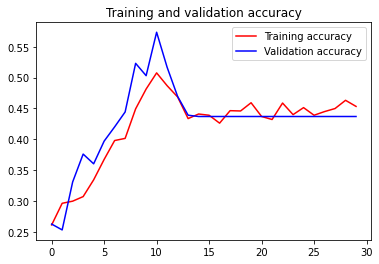

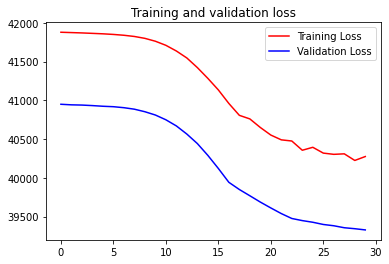

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Testing

In [ ]:
predictions = model.predict(x_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"RMSE --> {rmse:.02f}")

RMSE --> 199.97
